In [7]:
import numpy as np 
import gym
from gym import spaces
import random as rd

class NetworkOperatorEnv(gym.Env):
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self, n_cp, cache_capacity):
        
        rd.seed(5)
        self.alpha_list=[0.65, 0.85, 0.95]
        self.list_proba=[0.6, 0.30, 0.10]
        self.cons_zipf_1 = 8.13 
        self.cons_zipf_2 = 5.18
        self.cons_zipf_3 = 3.60
        self.conss_zipf = [self.cons_zipf_1, self.cons_zipf_2, self.cons_zipf_3]
        self.n_cp = n_cp
        self.cache_capacity = cache_capacity
        self.all_states = self._states_nCP(self.cache_capacity, self.n_cp)
        self.list_nb_video = self.list_100_videos(self.n_cp)
        self.rewards = []
        self.action_space = spaces.Discrete(7)
        self.observation_space = spaces.Discrete(len(self.all_states))
        self.nb_requests = 100
        self.current_r = 0
        self.nb_videos = 100
        self.current_step = 0
        self.max_steps = 100
    
    def _states_nCP(self, k,n):
        output_state_list=[]
        if n==1:
            output_state_list=[[n]]
        elif n==2:
            for j in range(k+1):
                output_state_list.append([j, k-j])
            return(output_state_list)
        else:
            for i in range (k+1):
                other_states = self._states_nCP(k-i,n-1)
                for state in other_states:
                    state.append(i)
                    output_state_list.append(state)
            return(output_state_list)
    
    def request_creation(self): #k
        sum=0
        i=0
        choice_CP = rd.random()
        while(True):
            sum = sum + self.list_proba[i]
            if(choice_CP <= sum):
                break
            else:
                i +=1
        CP = i
        distribution = self._zipf_distribution(self.alpha_list[i], self.list_nb_video[i], self.conss_zipf[i]) 
        choice_video = rd.random()
        counter_choice = 0
        for j in range(1, self.list_nb_video[i]+1):
            counter_choice += distribution[j-1]
            if counter_choice >= choice_video:
                selected_video = j
                break   
        return [CP, selected_video]
    
    def _zipf_distribution(self, alpha, nb_videos, norme): 
        norm = 0
        indices_videos = range(1, nb_videos+1)
        probabilites_pi = [0] * (nb_videos)
        for i in range(1, nb_videos+1):
            norm +=1.0/(i**alpha)
        for i in range(1, nb_videos+1):
            pi = (1.0/i**alpha) * (1.0/norm)
            probabilites_pi[i-1] = pi
        return probabilites_pi
    
    def list_100_videos(self, k):
        l=[]
        for i in range(k):
            l.append(100)
        return l
    
    def _decide_opt_alloc(self, k, cache_capacity): 
        distribution=[0]*k
        popularity=[0]*k
        allocation=[0]*k
        max_pointers=[0]*k
        
        if cache_capacity > sum(self.list_100_videos(k)):
            return 
        
        for i in range(k):
            distribution[i] = self._zipf_distribution(self.alpha_list[i], self.list_nb_video[i], self.conss_zipf[i])
            popularity[i] = [piyt * self.list_proba[i] for piyt in distribution[i]] #list for compare
            
        for j in range (cache_capacity):
            max_temp=0 
            for m in range(k-1):
                if popularity[m+1][max_pointers[m+1]]>popularity[m][max_pointers[m]]:
                    max_temp=m+1
            allocation[max_temp]=allocation[max_temp] + 1
            max_pointers[max_temp] = max_pointers[max_temp] + 1   
        return allocation
        
    def reset(self):
        self.current_step = 0
        self.state = self._decide_opt_alloc(self.n_cp, self.cache_capacity)
        self.max_steps = 100
        return self._next_observation()
    
    def _next_observation(self):
        self.obs = self.observation_space.sample()
        self.state = self.all_states[self.obs]
        return self.obs
    
    def _take_action(self, action):
        
        if action == 1:
            self.state[0] += 1
            self.state[1] -= 1
        if action == 2:
            self.state[0] -= 1
            self.state[1] += 1
        if action == 3:
            self.state[0] += 1
            self.state[2] -= 1
        if action == 4:
            self.state[0] -= 1
            self.state[2] += 1
        if action == 5:
            self.state[1] += 1
            self.state[2] -= 1
        if action == 6:
            self.state[1] -= 1
            self.state[2] += 1
    
    def state_position(self, alloc):
        counter = -1
        for k in self.all_states:
            counter +=1 ;
            if alloc == k:
                return counter
    
    def step(self, action):
        self.current_step += 1
        done = False
        self._take_action(action)
        reward = 0
        
        for r in range(1, self.nb_requests + 1):
            request = self.request_creation()
            content_provider = request[0]
            slots_allocated_to_that_content_provider = self.state[content_provider]
            video_id = request[1]
            if slots_allocated_to_that_content_provider > video_id:
                reward +=1
        obs = self._next_observation()
        return obs, reward, done, {}

    def render(self, mode='human', close=False):
        plt.title('Evaluation' )
        plt.xlabel('Number of iterations')
        plt.ylabel('cost')
        plt.grid('on')
        plt.close()
        plt.show()

In [13]:
def eps_greedy(Q, s, eps=0.1):
    if np.random.uniform(0,1) < eps:
        return np.random.randint(Q.shape[1])
    else:
        return greedy(Q, s)

def greedy(Q, s):
    return np.argmax(Q[s])

def Q_learning(env, lr=0.01, num_episodes=10000, eps=0.3, gamma=0.95, eps_decay=0.00005):
    nA = env.action_space.n
    nS = env.observation_space.n
    ind_ep =  []
    costs =  []
    Q = np.zeros((nS, nA))
    games_reward = []
    test_rewards = []

    for ep in range(num_episodes):
        state = env.reset()
        done = False
        tot_rew = 0
        if eps > 0.01:
            eps -= eps_decay
        action = eps_greedy(Q, state, eps) 
        next_state, rew, done, _ = env.step(action) 
        next_action = eps_greedy(Q, next_state, eps) 
        Q[state][action] = Q[state][action] + lr*(rew + gamma*np.max(Q[next_state]) - Q[state][action])
        state = next_state
        action = next_action
        tot_rew += rew
        games_reward.append(tot_rew)
        
        if (ep % 200) == 0:
            print("Episode:{:5d}  Eps:{:2.4f}  Rew:{:2.4f}".format(ep, eps, tot_rew))
            ind_ep.append(ep)
            costs.append(tot_rew)
    
    print(Q)
    plt.plot(ind_ep, costs)
    plt.title('QLearning Algorithm for Resource Allocation' )
    plt.xlabel('Number of episodes')
    plt.ylabel('Cost')
    plt.grid('on')
    plt.show()  

Episode:    0  Eps:0.3990  Rew:30.0000
Episode:  200  Eps:0.1990  Rew:36.0000
Episode:  400  Eps:0.0100  Rew:33.0000
Episode:  600  Eps:0.0100  Rew:20.0000
Episode:  800  Eps:0.0100  Rew:41.0000
Episode: 1000  Eps:0.0100  Rew:45.0000
Episode: 1200  Eps:0.0100  Rew:23.0000
Episode: 1400  Eps:0.0100  Rew:34.0000
Episode: 1600  Eps:0.0100  Rew:30.0000
Episode: 1800  Eps:0.0100  Rew:34.0000
Episode: 2000  Eps:0.0100  Rew:35.0000
Episode: 2200  Eps:0.0100  Rew:46.0000
Episode: 2400  Eps:0.0100  Rew:27.0000
Episode: 2600  Eps:0.0100  Rew:20.0000
Episode: 2800  Eps:0.0100  Rew:29.0000
Episode: 3000  Eps:0.0100  Rew:26.0000
Episode: 3200  Eps:0.0100  Rew:28.0000
Episode: 3400  Eps:0.0100  Rew:42.0000
Episode: 3600  Eps:0.0100  Rew:37.0000
Episode: 3800  Eps:0.0100  Rew:29.0000
Episode: 4000  Eps:0.0100  Rew:36.0000
Episode: 4200  Eps:0.0100  Rew:30.0000
Episode: 4400  Eps:0.0100  Rew:36.0000
Episode: 4600  Eps:0.0100  Rew:43.0000
Episode: 4800  Eps:0.0100  Rew:35.0000
Episode: 5000  Eps:0.0100

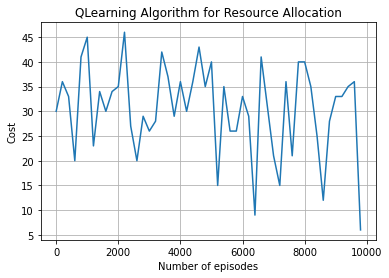

In [14]:
env = NetworkOperatorEnv(3, 30)
Q_learning(env, lr=.1, num_episodes=10000, eps=0.4, gamma=0.95, eps_decay=0.001)

In [8]:
import numpy as np 
import gym
from gym import spaces
import random as rd
import matplotlib.pyplot as plt

In [9]:
def eps_greedy(Q, s, eps=0.1):
    
    if np.random.uniform(0,1) < eps:
        return np.random.randint(Q.shape[1])
    else:
        return greedy(Q, s)

def greedy(Q, s):
    return np.argmax(Q[s])

def run_episodes(env, Q, num_episodes=100, to_print=False):
    tot_rew = []
    state = env.reset()
    for _ in range(num_episodes):
        done = False
        game_rew = 0

        while not done:
            next_state, rew, done, _ = env.step(greedy(Q, state))
            state = next_state
            game_rew += rew 
            if done:
                state = env.reset()
                tot_rew.append(game_rew)

    if to_print:
        print('Mean score: %.3f of %i games!'%(np.mean(tot_rew), num_episodes))
    return np.mean(tot_rew)

def SARSA(env, lr=0.01, num_episodes=10000, eps=0.3, gamma=0.95, eps_decay=0.00005):
    nA = env.action_space.n
    nS = env.observation_space.n
    ind_ep =  []
    costs =  []
    Q = np.zeros((nS, nA))
    rewards = []

    for ep in range(num_episodes):
        state = env.reset()
        done = False
        tot_rew = 0

        if eps > 0.01:
            eps -= eps_decay
        action = eps_greedy(Q, state, eps) 
        next_state, rew, done, _ = env.step(action) 
        next_action = eps_greedy(Q, next_state, eps) 
        Q[state][action] = Q[state][action] + lr*(rew + gamma*Q[next_state][next_action] - Q[state][action])
        state = next_state
        action = next_action
        tot_rew += rew
        rewards.append(tot_rew)
        
        if (ep % 200) == 0:
            print("Episode:{:5d}  Eps:{:2.4f}  Rew:{:2.4f}".format(ep, eps, tot_rew))
            ind_ep.append(ep)
            costs.append(tot_rew)
    
    print(Q)
    plt.plot(ind_ep, costs)
    plt.title('SARSA Algorithm for Resource Allocation' )
    plt.xlabel('Number of episodes')
    plt.ylabel('Cost')
    plt.grid('on')
    plt.show()  

Episode:    0  Eps:0.4990  Rew:13.0000
Episode:  200  Eps:0.2990  Rew:39.0000
Episode:  400  Eps:0.0990  Rew:44.0000
Episode:  600  Eps:0.0100  Rew:46.0000
Episode:  800  Eps:0.0100  Rew:41.0000
Episode: 1000  Eps:0.0100  Rew:44.0000
Episode: 1200  Eps:0.0100  Rew:33.0000
Episode: 1400  Eps:0.0100  Rew:30.0000
Episode: 1600  Eps:0.0100  Rew:34.0000
Episode: 1800  Eps:0.0100  Rew:23.0000
Episode: 2000  Eps:0.0100  Rew:43.0000
Episode: 2200  Eps:0.0100  Rew:40.0000
Episode: 2400  Eps:0.0100  Rew:35.0000
Episode: 2600  Eps:0.0100  Rew:27.0000
Episode: 2800  Eps:0.0100  Rew:37.0000
Episode: 3000  Eps:0.0100  Rew:21.0000
Episode: 3200  Eps:0.0100  Rew:30.0000
Episode: 3400  Eps:0.0100  Rew:15.0000
Episode: 3600  Eps:0.0100  Rew:16.0000
Episode: 3800  Eps:0.0100  Rew:30.0000
Episode: 4000  Eps:0.0100  Rew:21.0000
Episode: 4200  Eps:0.0100  Rew:27.0000
Episode: 4400  Eps:0.0100  Rew:24.0000
Episode: 4600  Eps:0.0100  Rew:39.0000
Episode: 4800  Eps:0.0100  Rew:27.0000
Episode: 5000  Eps:0.0100

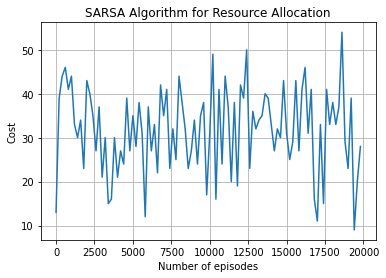

In [10]:
env = NetworkOperatorEnv(3, 30)
SARSA(env, lr=.9, num_episodes=20000, eps=0.5, gamma=0.95, eps_decay=0.001)